In [167]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.base import SpecLibBase

In [168]:
folder = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_27_alphadia_mDIA_synchroPasef/data_small_lib/'
label = '_d0.tsv'

In [169]:
raw_files = [os.path.join(folder,f) for f in os.listdir(folder) if f.endswith(label)]

In [170]:
df_list = []
for file in raw_files:
    run_df = pd.read_csv(file, sep='\t')
    run_df = run_df[run_df['qval'] < 0.01]
    run_df['run'] = os.path.basename(file)

    df_list.append(run_df)
df = pd.concat(df_list)

In [171]:
df['rt_deviation'] = df['rt_error'] / df['rt_calibrated']
df['mobility_deviation'] = df['mobility_error'] / df['mobility_calibrated']

In [172]:
rt_deviation = df.groupby('elution_group_idx', as_index=False)['rt_error'].agg(['median', 'std','count']).reset_index()
rt_deviation = rt_deviation.sort_values('elution_group_idx')
mobility_deviation = df.groupby('elution_group_idx', as_index=False)['mobility_error'].agg(['median', 'std','count']).reset_index()
mobility_deviation = mobility_deviation.sort_values('elution_group_idx')

valid_elution_groups = set(mobility_deviation['elution_group_idx'].unique()).intersection(set(rt_deviation['elution_group_idx'].unique()))

In [173]:
len(valid_elution_groups)

44067

In [174]:
input_lib_path = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_d12_shared_eg_n_fragments.hdf'
output_lib_path = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_d12_shared_eg_n_fragments_mbr.hdf'

input_lib = SpecLibBase()
input_lib.load_hdf(input_lib_path, load_mod_seq=True)

In [175]:
input_lib._precursor_df = input_lib._precursor_df[input_lib._precursor_df['elution_group_idx'].isin(valid_elution_groups)]
input_lib._precursor_df.sort_values('elution_group_idx', inplace=True)

In [176]:
input_lib._precursor_df.columns

Index(['charge', 'decoy', 'frag_start_idx', 'frag_stop_idx', 'mobility',
       'mod_seq_charge_hash', 'mod_seq_hash', 'nAA', 'precursor_mz', 'rt',
       'ccs', 'channel', 'elution_group_idx', 'genes', 'i_0', 'i_1', 'i_2',
       'i_3', 'i_4', 'i_5', 'mod_sites', 'mods', 'n_fragments',
       'n_fragments_allowed', 'proteins', 'rt_norm', 'sequence'],
      dtype='object')

In [177]:
rt_lookup = np.searchsorted(rt_deviation['elution_group_idx'].values, input_lib._precursor_df['elution_group_idx'].values)
input_lib._precursor_df['rt_norm'] = input_lib._precursor_df['rt_norm'] + input_lib._precursor_df['rt_norm'] * rt_deviation['median'].values[rt_lookup]
mobility_lookup = np.searchsorted(mobility_deviation['elution_group_idx'].values, input_lib._precursor_df['elution_group_idx'].values)
input_lib._precursor_df['mobility'] = input_lib._precursor_df['mobility'] + input_lib._precursor_df['mobility'] * mobility_deviation['median'].values[mobility_lookup]

In [178]:
input_lib.remove_unused_fragments()

<AxesSubplot:>

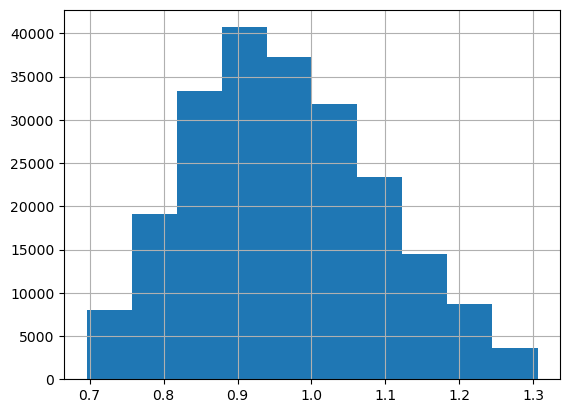

In [179]:
input_lib._precursor_df['mobility'].hist()

In [180]:
input_lib.save_hdf(output_lib_path)

In [285]:
diann_export_lib = input_lib.copy()
diann_export_lib._precursor_df = diann_export_lib._precursor_df[diann_export_lib._precursor_df['channel'] == 0]
diann_export_lib._precursor_df = diann_export_lib._precursor_df[diann_export_lib._precursor_df['decoy'] == 0]

In [287]:
from alphabase.spectral_library import translate

diann_df = translate.speclib_to_single_df(diann_export_lib)

44067it [00:04, 9246.09it/s] 


In [289]:
diann_df.to_csv('/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_d12_shared_eg_n_fragments_mbr.tsv', sep='\t', index=False)